In [ ]:
#@title Импорты
import os
import numpy as np
import pandas as pd
from joblib import dump, load
import tensorflow as tf
from pathlib import Path
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
import PIL.Image
import time
import functools
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

In [ ]:
#@title Подключение к Spotify API
!pip install spotipy

MY_USERNAME = '31itta4co6qz3ivppf6ci5vv47de'
MY_APP_CLIENT_ID = '998f166cea214ad6a6c950f085ff56f9'
MY_APP_CLIENT_SECRET = '4f0297f9735d4cf38e79d4f5d32bfc49'

import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=MY_APP_CLIENT_ID,
                                                           client_secret=MY_APP_CLIENT_SECRET))

In [ ]:
#@title Выбор трека и извлечение признаков

artist = 'gotye'
track = 'somebody that i used to know'
search = sp.search(q='artist:' + artist + ' track:' + track, type='track')
trackID = search['tracks']['items'][0]['id']
track_name = search['tracks']['items'][0]['name']
first_artist_name = search['tracks']['items'][0]['album']['artists'][0]['name']
features = sp.audio_features([trackID])
features = pd.DataFrame.from_dict(features)[['acousticness', 'danceability', 'energy', 'liveness', 'mode', 'speechiness', 'tempo', 'valence']]
features

,acousticness,danceability,energy,liveness,mode,speechiness,tempo,valence
0,0.591,0.864,0.495,0.0992,1,0.037,129.062,0.72


In [ ]:
#@title Определение настроений выбранного трека
def base_model():
    model = Sequential()
    model.add(Dense(8,input_dim=8,activation='relu'))
    model.add(Dense(6,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',
              metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=base_model,epochs=5000, batch_size=200, verbose=1)

estimator = load('/content/drive/MyDrive/DATASET/mood_classifier.joblib')
y_preds = estimator.predict_proba(features)
track_moods = pd.DataFrame(data = y_preds, columns=['agr', 'chill', 'happy', 'love', 'sad', 'spooky'])
track_moods

1/1 [==============================] - 0s 42ms/step


<ipython-input-41-8e0fdb630fc1>:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=base_model,epochs=5000, batch_size=200, verbose=1)


,agr,chill,happy,love,sad,spooky
0,0.000002,0.109544,0.011297,0.640332,0.077763,0.161062


In [ ]:
#@title Таблица с настроениями изображений

images_moods = pd.read_excel('/content/drive/MyDrive/DATASET/images_moods.xlsx', index_col=0)
images_moods = images_moods[['Image URL', 'anger', 'humility', 'happiness', 'love', 'sadness', 'fear']]

In [ ]:
#@title Вычисление матрицы Грама генерируемого изображения

sum_weight = 0
gram_matrices_path = '/content/drive/MyDrive/DATASET/gram_matrices'
style_target = np.zeros(shape=(1, 64, 64)) #init gram matrix which will be formed
for filename in os.listdir(gram_matrices_path):
  img_id = filename[:-4]
  gr_m_path = os.path.join(gram_matrices_path, filename)
  gr_m = tf.convert_to_tensor(np.load(gr_m_path))
  image_moods =  images_moods.loc[img_id].values[1:]
  mood_dist = np.linalg.norm(track_moods.values - image_moods)
  weight = 1/(mood_dist ** 4)
  sum_weight += weight
  style_target += weight * gr_m
style_target = style_target/sum_weight

In [ ]:
#@title Функции
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


In [ ]:
#@title Создание модели для извлечения представления стиля
content_layers = ['block5_conv2']
style_layers = ['block1_conv1']
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

extractor = StyleContentModel(style_layers, content_layers)

In [ ]:
#@title Белый шум

white_noise = tf.random.normal([1, 512, 512, 3])
image = tf.Variable(white_noise)

In [ ]:
#@title Content image

content_image = load_img('/content/drive/MyDrive/DATASET/test_images/CsSpVVPIRnc.jpg')
content_targets = extractor(content_image)['content']
image = tf.Variable(content_image)

In [ ]:
#@title Функция потерь (только для стиля)

style_weight=1e-2
content_weight=1e4

def style_loss(outputs):
    style_outputs = outputs['style']
    #content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_target)**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    #content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
     #                        for name in content_outputs.keys()])
    #content_loss *= content_weight / num_content_layers
    #loss = style_loss + content_loss
    return style_loss

In [ ]:
#@title Функция потерь (для стиля+содержимого)

style_weight=1e-2
content_weight=1e4

def content_style_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_target)**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [ ]:
#@title Шаг изменения изображения

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_loss(outputs)  #если хотим только стиль
    #loss = content_style_loss(outputs) #если хотим изменить content image

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

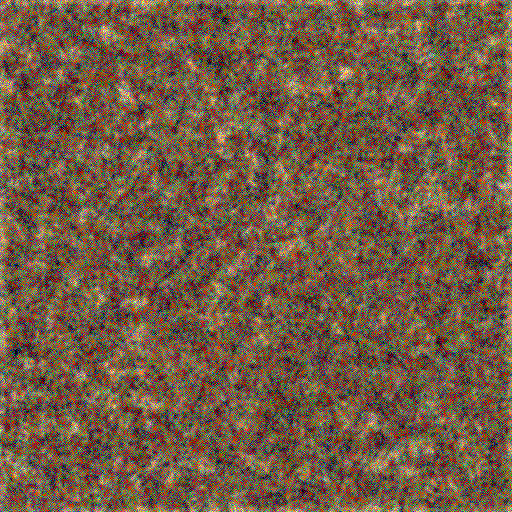

Train step: 500
Total time: 5.5


In [ ]:
#@title Генерация изображения

import time
start = time.time()

epochs = 5
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

In [ ]:
#@title Мои плейлисты
playlists = sp.user_playlists(MY_USERNAME)
while playlists:
    for i, playlist in enumerate(playlists['items']):
        print("%4d %s %s" % (i + 1 + playlists['offset'], playlist['uri'],  playlist['name']))
    if playlists['next']:
        playlists = sp.next(playlists)
    else:
        playlists = None

In [ ]:
#@title Формирование таблиц с песнями по настроениям

prog_id = '3Gf42v6ThN8M4ej7EivwEl'
love_id = '37i9dQZF1DX50QitC6Oqtn'
spooky_id = '37i9dQZF1DX5hol82XuK24'
agressive_id = '39ySLYG9qZeupGMyVsW5sE'
sad_id = '37i9dQZF1DWVrtsSlLKzro'
chill_id = '37i9dQZF1DX6VdMW310YC7'
happy_id = '37i9dQZF1DWSf2RDTDayIx'
happy_test_id = '37i9dQZF1DXdPec7aLTmlC'

love_songs = []
for i, item in enumerate(sp.user_playlist_tracks(MY_USERNAME, love_id)['items']):
  track_id = item['track']['id']
  track_name = item['track']['name']
  track_artist = item['track']['artists'][0]['name']
  track_features = sp.audio_features([track_id])[0]
  track_features['name'] = track_name
  track_features['artist'] = track_artist
  track_features['mood'] = 'love'
  love_songs.append(track_features)
love_songs = pd.DataFrame.from_dict(love_songs)
love_songs.to_excel('/content/drive/MyDrive/DATASET/mood_playlists/love_songs.xlsx')

spooky_songs = []
for i, item in enumerate(sp.user_playlist_tracks(MY_USERNAME, spooky_id)['items']):
  track_id = item['track']['id']
  track_name = item['track']['name']
  track_artist = item['track']['artists'][0]['name']
  track_features = sp.audio_features([track_id])[0]
  track_features['name'] = track_name
  track_features['artist'] = track_artist
  track_features['mood'] = 'spooky'
  spooky_songs.append(track_features)
spooky_songs = pd.DataFrame.from_dict(spooky_songs)
spooky_songs.to_excel('/content/drive/MyDrive/DATASET/mood_playlists/spooky_songs.xlsx')

agressive_songs = []
for i, item in enumerate(sp.user_playlist_tracks(MY_USERNAME, agressive_id)['items']):
  track_id = item['track']['id']
  track_name = item['track']['name']
  track_artist = item['track']['artists'][0]['name']
  track_features = sp.audio_features([track_id])[0]
  track_features['name'] = track_name
  track_features['artist'] = track_artist
  track_features['mood'] = 'agressive'
  agressive_songs.append(track_features)
agressive_songs = pd.DataFrame.from_dict(agressive_songs)
agressive_songs.to_excel('/content/drive/MyDrive/DATASET/mood_playlists/agressive_songs.xlsx')

sad_songs = []
for i, item in enumerate(sp.user_playlist_tracks(MY_USERNAME, sad_id)['items']):
  track_id = item['track']['id']
  track_name = item['track']['name']
  track_artist = item['track']['artists'][0]['name']
  track_features = sp.audio_features([track_id])[0]
  track_features['name'] = track_name
  track_features['artist'] = track_artist
  track_features['mood'] = 'sad'
  sad_songs.append(track_features)
sad_songs = pd.DataFrame.from_dict(sad_songs)
sad_songs.to_excel('/content/drive/MyDrive/DATASET/mood_playlists/sad_songs.xlsx')

chill_songs = []
for i, item in enumerate(sp.user_playlist_tracks(MY_USERNAME, chill_id)['items']):
  track_id = item['track']['id']
  track_name = item['track']['name']
  track_artist = item['track']['artists'][0]['name']
  track_features = sp.audio_features([track_id])[0]
  track_features['name'] = track_name
  track_features['artist'] = track_artist
  track_features['mood'] = 'chill'
  chill_songs.append(track_features)
chill_songs = pd.DataFrame.from_dict(chill_songs)
chill_songs.to_excel('/content/drive/MyDrive/DATASET/mood_playlists/chill_songs.xlsx')

happy_songs = []
for i, item in enumerate(sp.user_playlist_tracks(MY_USERNAME, happy_id)['items']):
  track_id = item['track']['id']
  track_name = item['track']['name']
  track_artist = item['track']['artists'][0]['name']
  track_features = sp.audio_features([track_id])[0]
  track_features['name'] = track_name
  track_features['artist'] = track_artist
  track_features['mood'] = 'happy'
  happy_songs.append(track_features)
happy_songs = pd.DataFrame.from_dict(happy_songs)
happy_songs.to_excel('/content/drive/MyDrive/DATASET/mood_playlists/happy_songs.xlsx')

prog_songs = []
for i, item in enumerate(sp.user_playlist_tracks(MY_USERNAME, prog_id)['items']):
  track_id = item['track']['id']
  track_name = item['track']['name']
  track_artist = item['track']['artists'][0]['name']
  track_features = sp.audio_features([track_id])[0]
  track_features['name'] = track_name
  track_features['artist'] = track_artist
  prog_songs.append(track_features)
prog_songs = pd.DataFrame.from_dict(prog_songs)

happy_test_songs = []
for i, item in enumerate(sp.user_playlist_tracks(MY_USERNAME, happy_test_id)['items']):
  track_id = item['track']['id']
  track_name = item['track']['name']
  track_artist = item['track']['artists'][0]['name']
  track_features = sp.audio_features([track_id])[0]
  track_features['name'] = track_name
  track_features['artist'] = track_artist
  happy_test_songs.append(track_features)
happy_test_songs = pd.DataFrame.from_dict(happy_test_songs)

In [ ]:
#@title Загрузка и предобработка данных
love_songs = pd.read_excel('/content/drive/MyDrive/DATASET/mood_playlists/love_songs.xlsx', index_col=0)
spooky_songs = pd.read_excel('/content/drive/MyDrive/DATASET/mood_playlists/spooky_songs.xlsx', index_col=0)
happy_songs = pd.read_excel('/content/drive/MyDrive/DATASET/mood_playlists/happy_songs.xlsx', index_col=0)
sad_songs = pd.read_excel('/content/drive/MyDrive/DATASET/mood_playlists/sad_songs.xlsx', index_col=0)
chill_songs = pd.read_excel('/content/drive/MyDrive/DATASET/mood_playlists/chill_songs.xlsx', index_col=0)
agressive_songs = pd.read_excel('/content/drive/MyDrive/DATASET/mood_playlists/agressive_songs.xlsx', index_col=0)

train = pd.concat([love_songs, spooky_songs, happy_songs, sad_songs, chill_songs, agressive_songs], ignore_index=True)
train = train[['acousticness', 'danceability', 'energy', 'liveness', 'mode', 'speechiness', 'tempo', 'valence', 'mood']]

le = preprocessing.LabelEncoder() #agr 0, chill 1, happy 2, love 3, sad 4, spooky 5
train['mood'] = le.fit_transform(train['mood'])

X_train = train.drop('mood', axis=1)
Y_train = train['mood']
Happy_test = happy_test_songs[['acousticness', 'danceability', 'energy', 'liveness', 'mode', 'speechiness', 'tempo', 'valence']]

In [ ]:
#@title Создание и обучение модели
def base_model():
    model = Sequential()
    model.add(Dense(8,input_dim=8,activation='relu'))
    model.add(Dense(6,activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',
              metrics=['accuracy'])
    return model

estimator = KerasClassifier(build_fn=base_model,epochs=5000, batch_size=200, verbose=1)
estimator.fit(X_train,Y_train)

dump(estimator, '/content/drive/MyDrive/DATASET/mood_classifier.joblib')